# Create close up plots of segmentation for TA2 (Pregnant)

Load libraries.

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import spatialdata_io
import spatialdata as sd

import geopandas as gpd
import spatialdata_plot
from spatialdata import bounding_box_query
import os

Set figure directory.

In [7]:
sc.settings.figdir = "../output/merged_analysis/segmentation_plots_publication/"

Read in Xenium data.

In [3]:
sdata = spatialdata_io.xenium("../20240704__113302__040724_Tomo_mouse_gutroll_run1/output-XETG00207__0034181__TA2__20240704__113512", cells_as_shapes =  True)

INFO     reading                                                                                                   
         ../20240704__113302__040724_Tomo_mouse_gutroll_run1/output-XETG00207__0034181__TA2__20240704__113512/cell_
         feature_matrix.h5                                                                                         


/tmp/slurm_8487764/ipykernel_39415/1393038037.py:1: DeprecationWarning: `cells_as_shapes` is being deprecated as an argument to `xenium.xenium` in SpatialData version 0.1, switch to `cells_as_circles` instead.
  sdata = spatialdata_io.xenium("../20240704__113302__040724_Tomo_mouse_gutroll_run1/output-XETG00207__0034181__TA2__20240704__113512", cells_as_shapes =  True)


Read in clusters from analysis.

In [4]:
annotations = pd.read_csv("../output/merged_analysis_nuclei/nuclei_meta.csv")
annotations["cell"] = annotations.iloc[:,0]

Prepare transcriptomic later and add cluster information.

In [6]:
sample = "TA2"
sample_anno = annotations.loc[annotations["sample"] == sample,:]
sample_anno.index = sample_anno["cell"]
cells = list(sample_anno["cell"])
sdata.table.obs_names = sdata.table.obs['cell_id']
adata = sdata.table
adata = adata[cells]
adata.obs["cluster"] = list(sample_anno['epi_res0.5'])
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
del sdata.table
sdata.table = adata
print("sdata prepared")

/tmp/slurm_8487764/ipykernel_39415/2839371184.py:5: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  sdata.table.obs_names = sdata.table.obs['cell_id']
/tmp/slurm_8487764/ipykernel_39415/2839371184.py:6: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  adata = sdata.table
/tmp/slurm_8487764/ipykernel_39415/2839371184.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["cluster"] = list(sample_anno['epi_res0.5'])


sdata prepared


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/tmp/slurm_8487764/ipykernel_39415/2839371184.py:12: DeprecationWarning: del sdata.table will be deprecated with SpatialData version 0.1, use del sdata.tables['table'] instead.
  del sdata.table
/tmp/slurm_8487764/ipykernel_39415/2839371184.py:13: DeprecationWarning: Table setter will be deprecated with SpatialData version 0.1, use tables instead.
  sdata.table = adata


Set colour palette for plots.

In [ ]:
polychrome = ["#5A5156", "#E4E1E3", "#F6222E", "#FE00FA", "#16FF32",\
          "#3283FE", "#FEAF16", "#B00068", "#1CFFCE", "#90AD1C",\
        "#2ED9FF", "#DEA0FD", "#AA0DFE", "#F8A19F", "#325A9B",\
          "#C4451C", "#1C8356", "#85660D", "#B10DA1", "#FBE426",\
          "#1CBE4F", "#FA0087", "#FC1CBF", "#F7E1A0", "#C075A6",\
          "#782AB6", "#AAF400", "#BDCDFF"]

Extract coordinates.

In [11]:
coords = pd.DataFrame(sdata.table.obsm["spatial"])

/tmp/slurm_8487764/ipykernel_4080649/751507538.py:1: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  coords = pd.DataFrame(sdata.table.obsm["spatial"])


Plot to select ROI.

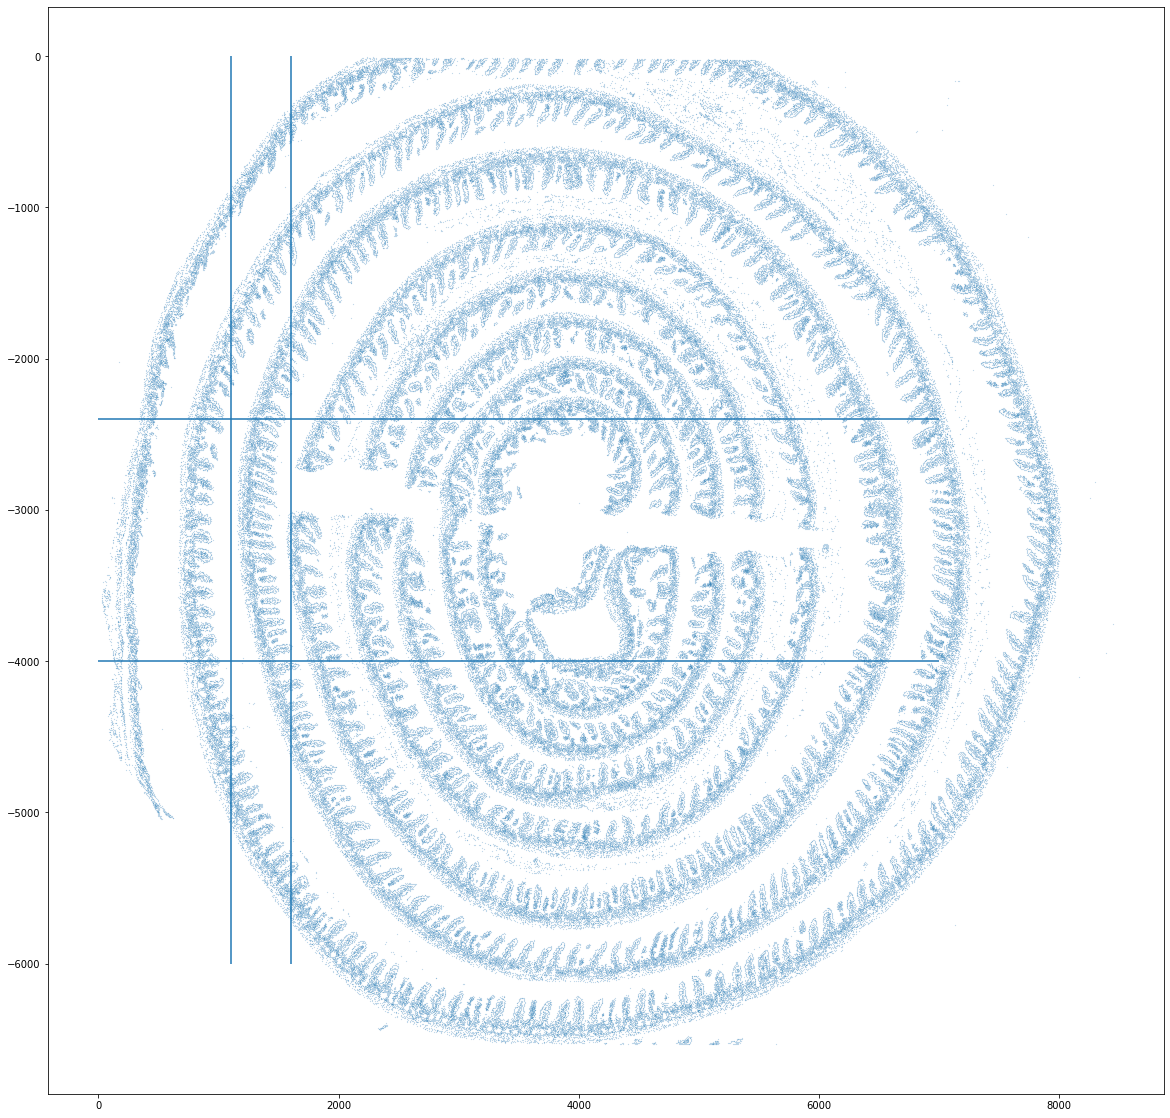

In [12]:
plt.figure(figsize=(20,20))
plt.scatter(coords.loc[:,0],-(coords.loc[:,1]), s = 0.01)
plt.vlines(x = 1100, ymin = -6000, ymax = 0)
plt.vlines(x = 1600, ymin = -6000, ymax = 0)
plt.hlines(y = -2400, xmin = 0, xmax = 7000)
plt.hlines(y = -4000, xmin = 0, xmax = 7000)

Get rough conversion of ROI to pixels.

In [9]:
f =  1/0.2125
print(1100*f)
print(2400*f)
print(1600*f)
print(4000*f)

5176.470588235295
11294.117647058823
7529.411764705883
18823.529411764706


Set metadata (clusters) to link to cell boundaries.

In [9]:
sdata.tables["table"].obs["region"] = "cell_boundaries"
sdata.set_table_annotates_spatialelement("table", region="cell_boundaries")

/opt/conda/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:474: UserWarning: Converting `region_key: region` to categorical dtype.
  convert_region_column_to_categorical(table)


Crop data to ROI.

In [7]:
cropped_sdata = sdata.query.bounding_box(
axes=["x", "y"],
min_coordinate=[5000, 12000],
max_coordinate=[7600, 18900],
target_coordinate_system="global",
)

Prepare data for plotting.

In [ ]:
print("sdata cropped")
cropped_sdata.table.obs["cluster"] = pd.Categorical(cropped_sdata.table.obs["cluster"])
groups = list(cropped_sdata.table.obs["cluster"].cat.categories)
groups = [str(i) for i in groups]
cropped_sdata.table.obs["cluster_str"] = cropped_sdata.table.obs["cluster"].astype(str)
cropped_sdata.table.obs["cluster_str"] = pd.Categorical(cropped_sdata.table.obs["cluster_str"], categories = groups)

Filter cropped data cell boundaries to those whose centroids are included in the cropped data.

In [11]:
cropped_sdata["cell_boundaries"] = cropped_sdata["cell_boundaries"].loc[cropped_sdata.table.obs_names,:]

/tmp/slurm_8487764/ipykernel_39415/1890243967.py:1: DeprecationWarning: Table accessor will be deprecated with SpatialData version 0.1, use sdata.tables instead.
  cropped_sdata["cell_boundaries"] = cropped_sdata["cell_boundaries"].loc[cropped_sdata.table.obs_names,:]
/opt/conda/lib/python3.10/site-packages/spatialdata/_core/_elements.py:96: UserWarning: Key `cell_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Plot epithelial clusters and segmentations.

In [ ]:
cropped_sdata.pl.render_shapes(elements="cell_boundaries", outline_width=0.5, outline = True, color = "cluster_str",palette = polychrome[:19], groups = groups).pl.show(title=f"", coordinate_systems="global", figsize=(20, 20), save = sample + "_cluster_image.png")

Plot over image.

In [ ]:
cropped_sdata.pl.render_images("morphology_focus").pl.render_shapes(elements="cell_boundaries", outline_width=0.5, fill_alpha=0.5,outline = True, color = "cluster_str",palette = polychrome[:19], groups = groups).pl.show(title=f"", coordinate_systems="global", figsize=(20, 20), save = sample + "_cluster_image_alpha0.5_over_morphology.png")